In [1]:
# !pip install tensorflow==2.9.1

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

2024-02-10 01:31:34.425718: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-10 01:31:34.428105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-02-10 01:31:34.428111: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [243]:
# Function to read and preprocess data from a directory
def read_and_preprocess_mfcc(directory, state="mfccs_delta_dd"):
    coeffs= int(directory[-2:])
    class_data = []
    labels = []

    for class_label, class_name in enumerate(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            df = pd.read_csv(file_path)
            if df.shape != (130, 66):
                print("short utterance")
                # print(file_path)
                # print(df.shape)
                mean_df = df.mean()
                # print("mean calculated")

                for _ in range(130 - df.shape[0]):
                    df = pd.concat([df, mean_df.to_frame().T], ignore_index=True)                    
                print("length increased by mean")
                print(df.shape)
            if state == "mfccs":
                df = df.iloc[:, :coeffs]
            elif state == "mfccs_delta":
                df = df.iloc[:, :coeffs*2]
            # df = df.mean()
            # print("df mean shape: ", df.shape)
            # print(df)
            # Assuming each CSV file contains a 20x129 2D array
            class_data.append(df.values)
            labels.append(class_name)
    print("df shape: ", df.shape)   
    print("class_data shape: ", np.array(class_data).shape)   
    return np.array(class_data), np.array(labels), df.shape

In [77]:
def cnn_model(classes_num):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(499, 40)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(classes_num, activation='softmax'))
    return model

In [78]:
from tensorflow.keras.layers import BatchNormalization, Dropout
import tensorflow as tf

In [79]:
import matplotlib.pyplot as plt

In [80]:
def complex_cnn_model(classes_num, input_shape=(499, 20)):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(classes_num, activation='softmax'))
    return model

In [81]:
def complex_cnn_model_2(classes_num, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())  # Batch normalization added
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))  # Dropout layer added

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())  # Batch normalization added
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))  # Dropout layer added

    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())  # Batch normalization added
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))  # Dropout layer added

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(classes_num, activation='softmax'))
    return model

In [312]:
# start from here
# Load training data
tests = ["unnormalized", "normalized", "noise_processed"]
test = "noise_processed"

cases = ["mfccs", "mfccs_delta", ""]
case = ""

training_directory = f"{test}_training_mfcc22"
classes_num = len(os.listdir(training_directory))
X_train, y_train, df_shape = read_and_preprocess_mfcc(training_directory, case)
print(df_shape)
# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
# One-hot encode labels
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the CNN model
# model = cnn_model(classes_num)
# model = complex_cnn_model(classes_num)
model = complex_cnn_model_2(classes_num, df_shape)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()



df shape:  (130, 66)
class_data shape:  (180, 130, 66)
(130, 66)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_87 (Conv1D)          (None, 128, 64)           12736     
                                                                 
 batch_normalization_87 (Bat  (None, 128, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_87 (MaxPoolin  (None, 64, 64)           0         
 g1D)                                                            
                                                                 
 dropout_116 (Dropout)       (None, 64, 64)            0         
                                                                 
 conv1d_88 (Conv1D)          (None, 62, 128)           24704     
                                                      

In [313]:
# Train the model
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val))
# model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
18/18 [==============================] - 1s 12ms/step - loss: 2.9460 - accuracy: 0.1806 - val_loss: 3.0549 - val_accuracy: 0.1944
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 1.8808 - accuracy: 0.2986 - val_loss: 2.2933 - val_accuracy: 0.1389
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 1.3258 - accuracy: 0.5069 - val_loss: 2.1928 - val_accuracy: 0.2500
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 1.0758 - accuracy: 0.6111 - val_loss: 1.5404 - val_accuracy: 0.3056
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.9628 - accuracy: 0.6667 - val_loss: 1.2418 - val_accuracy: 0.5000
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.7939 - accuracy: 0.7014 - val_loss: 1.2963 - val_accuracy: 0.4722
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.8056 - val_loss: 1.2026 - val_accuracy: 0.4167
Epoch 8/100


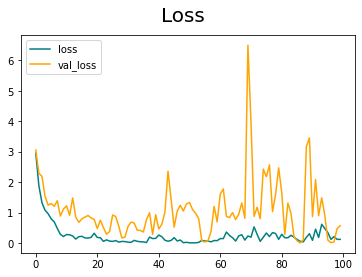

In [314]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

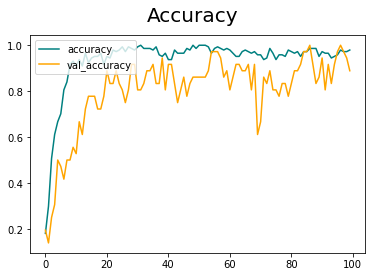

In [315]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [316]:
from sklearn.metrics import accuracy_score

# Load testing data
testing_directory = f"{test}_testing_same_mfcc22"
X_test, y_test, _ = read_and_preprocess_mfcc(testing_directory, case)

# Convert lists to numpy arrays
X_test = np.array(X_test)

print(len(X_test))
# X_test = X_test.astype(np.float32)
# X_test = np.asarray(X_test).astype(np.float32)

y_test = np.array(y_test)

# One-hot encode labels
y_test = to_categorical(label_encoder.transform(y_test))

# Get the predictions of the model on the testing data
predictions = model.predict(X_test)


# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Inverse transform the predicted labels to get the class names
predicted_class_names = label_encoder.inverse_transform(predicted_labels)

# Print the class names of the predictions
# print("Predicted Class Names:", predicted_class_names)


# Get the actual labels
actual_labels = np.argmax(y_test, axis=1)


# Inverse transform the predicted labels to get the class names
actual_class_names = label_encoder.inverse_transform(actual_labels)

# Print the class names of the predictions
# print("Actual Class Names:", actual_class_names)

# Calculate the accuracy score
accuracy = accuracy_score(actual_labels, predicted_labels)

# Print the accuracy score
print("Accuracy:", round(accuracy,4))


df shape:  (130, 66)
class_data shape:  (120, 130, 66)
120
4/4 [==============================] - 0s 3ms/step
Accuracy: 0.775


In [317]:
from sklearn.metrics import accuracy_score

# Load testing data
testing_directory = f"{test}_testing_different_mfcc22"
X_test, y_test, _ = read_and_preprocess_mfcc(testing_directory, case)

# Convert lists to numpy arrays
X_test = np.array(X_test)

print(len(X_test))
# X_test = X_test.astype(np.float32)
# X_test = np.asarray(X_test).astype(np.float32)

y_test = np.array(y_test)

# One-hot encode labels
y_test = to_categorical(label_encoder.transform(y_test))

# Get the predictions of the model on the testing data
predictions = model.predict(X_test)


# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Inverse transform the predicted labels to get the class names
predicted_class_names = label_encoder.inverse_transform(predicted_labels)

# Print the class names of the predictions
# print("Predicted Class Names:", predicted_class_names)


# Get the actual labels
actual_labels = np.argmax(y_test, axis=1)


# Inverse transform the predicted labels to get the class names
actual_class_names = label_encoder.inverse_transform(actual_labels)

# Print the class names of the predictions
# print("Actual Class Names:", actual_class_names)

# Calculate the accuracy score
accuracy = accuracy_score(actual_labels, predicted_labels)

# Print the accuracy score
print("Accuracy:", round(accuracy, 4))


short utterance
length increased by mean
(130, 66)
short utterance
length increased by mean
(130, 66)
short utterance
length increased by mean
(130, 66)
df shape:  (130, 66)
class_data shape:  (48, 130, 66)
48
2/2 [==============================] - 0s 3ms/step
Accuracy: 0.3333


In [318]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:
import pickle

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [ ]:
if accuracy > 0.9787234042553191:
    model.save('speaker identifier.h5')

# Test a sample

In [ ]:
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

In [ ]:
from sklearn.metrics import accuracy_score

# Load testing data
testing_directory = "6-mfcc_dataset/testing"
X_test, y_test = read_and_preprocess_mfcc(testing_directory)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# One-hot encode labels
y_test = to_categorical(label_encoder.transform(y_test))

# Get the predictions of the model on the testing data
predictions = model.predict(X_test)


# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Inverse transform the predicted labels to get the class names
predicted_class_names = label_encoder.inverse_transform(predicted_labels)

# Print the class names of the predictions
print("Predicted Class Names:", predicted_class_names)


# Get the actual labels
actual_labels = np.argmax(y_test, axis=1)


# Inverse transform the predicted labels to get the class names
actual_class_names = label_encoder.inverse_transform(actual_labels)

# Print the class names of the predictions
print("Actual Class Names:", actual_class_names)

# Calculate the accuracy score
accuracy = accuracy_score(actual_labels, predicted_labels)

# Print the accuracy score
print("Accuracy:", accuracy)


4/4 [==============================] - 0s 1ms/step
Predicted Class Names: ['Sherif' 'Sherif' 'Sherif' 'Sherif' 'Sherif' 'Sherif' 'Sherif' 'Sherif'
 'Sherif' 'Sherif' 'Sherif' 'Sherif' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'S' 'A'
 'A' 'A' 'A' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'L' 'L' 'S' 'L'
 'L' 'L' 'S' 'L' 'L' 'L' 'L' 'S' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y'
 'Y' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'Reem' 'Reem'
 'Reem' 'Reem' 'Reem' 'Reem' 'Reem' 'Reem' 'Reem' 'Reem' 'Reem' 'Renad'
 'Renad' 'Renad' 'Renad' 'Renad' 'Renad' 'Renad' 'Renad' 'Renad' 'Renad'
 'Renad' 'Renad' 'L' 'Renad' 'Renad' 'Renad' 'Renad' 'Renad' 'Renad'
 'Renad' 'Renad' 'Renad' 'Renad']
Actual Class Names: ['Sherif' 'Sherif' 'Sherif' 'Sherif' 'Sherif' 'Sherif' 'Sherif' 'Sherif'
 'Sherif' 'Sherif' 'Sherif' 'Sherif' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'L' 'L' 'L' 'L'
 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y'

In [ ]:
import pyaudio
import sounddevice
import wave
import librosa
import numpy as np
from keras.models import load_model
import pandas as pd


In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
WAVE_OUTPUT_FILENAME = "enrollment3.wav"

In [ ]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
RECORD_SECONDS = 1
# train_path = ".\dataset\encodings\\s_1.npy"
# test_path = ".\dataset\encodings\\r_1.npy"

record = True

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("Started recording...")
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)


stream.stop_stream()
stream.close()
p.terminate()

required_frames_size = 96
print(len(frames))
new_frames = frames.copy()
while len(new_frames) < required_frames_size:
    new_frames.extend(frames)
new_frames = new_frames[:required_frames_size]

print(len(new_frames))
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(new_frames))
wf.close()

Started recording...


In [ ]:
file_path = WAVE_OUTPUT_FILENAME
file_name = file_path.split('.')[0]
output_path = "./sample tests/temp/"
signal, sr = librosa.load(file_path, duration=5)
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=22, sr=sr)
test_sample = [mfccs]
test_sample = np.array(test_sample)
test_sample.shape

(1, 22, 216)

In [ ]:
# model = load_model('speaker identifier.h5')
# Load the label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

In [ ]:
from sklearn.metrics import accuracy_score

# Get the predictions of the model on the testing data
predictions = model.predict(test_sample)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Inverse transform the predicted labels to get the class names
predicted_class_names = label_encoder.inverse_transform(predicted_labels)

# Print the class names of the predictions
print("Predicted Class Names:", predicted_class_names)
print(label_encoder.classes_)
print(f"max prob: {predictions.max()} as {label_encoder.classes_[np.argmax(predictions)]}")
print(f"second max prob: {np.sort(predictions)[0][-2]} as {label_encoder.classes_[np.argsort(predictions)[0][-2]]}")
print(f"third max prob: {np.sort(predictions)[0][-3]} as {label_encoder.classes_[np.argsort(predictions)[0][-3]]}")

1/1 [==============================] - 0s 52ms/step
Predicted Class Names: ['L']
['A' 'L' 'O' 'Reem' 'Renad' 'S' 'Sherif' 'Y']
max prob: 0.9712963700294495 as L
second max prob: 0.020499570295214653 as Renad
third max prob: 0.004142431076616049 as S


In [ ]:
stop here

1/1 [==============================] - 0s 11ms/step
Predicted Class Names: ['Sherif']
['A' 'L' 'O' 'Reem' 'Renad' 'S' 'Sherif' 'Y']
max prob: 1.0 as Sherif
second max prob: 5.361565792033618e-12 as S
third max prob: 8.982738665852703e-15 as Y

SyntaxError: invalid decimal literal (2536742902.py, line 3)

In [ ]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
RECORD_SECONDS = 1
# train_path = ".\dataset\encodings\\s_1.npy"
# test_path = ".\dataset\encodings\\r_1.npy"

record = True

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("Started recording...")
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)


stream.stop_stream()
stream.close()
p.terminate()

required_frames_size = 96
print(len(frames))
new_frames = frames.copy()
while len(new_frames) < required_frames_size:
    new_frames.extend(frames)
new_frames = new_frames[:required_frames_size]

print(len(new_frames))
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(new_frames))
wf.close()


file_path = WAVE_OUTPUT_FILENAME
signal, sr = librosa.load(file_path, duration=5)
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=22, sr=sr)
test_sample = [mfccs]
test_sample = np.array(test_sample)
print(test_sample.shape)
# Get the predictions of the model on the testing data
predictions = model.predict(test_sample)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Inverse transform the predicted labels to get the class names
predicted_class_names = label_encoder.inverse_transform(predicted_labels)

# Print the class names of the predictions
print("Predicted Class Names:", predicted_class_names)
print(label_encoder.classes_)
print(f"max prob: {predictions.max()} as {label_encoder.classes_[np.argmax(predictions)]}")
print(f"second max prob: {np.sort(predictions)[0][-2]} as {label_encoder.classes_[np.argsort(predictions)[0][-2]]}")
print(f"third max prob: {np.sort(predictions)[0][-3]} as {label_encoder.classes_[np.argsort(predictions)[0][-3]]}")

Started recording...
15
96
(1, 22, 216)
1/1 [==============================] - 0s 13ms/step
Predicted Class Names: ['Sherif']
['A' 'L' 'O' 'Reem' 'Renad' 'S' 'Sherif' 'Y']
max prob: 0.9982902407646179 as Sherif
second max prob: 0.0012117248261347413 as L
third max prob: 0.00030369008891284466 as S
